<a href="https://colab.research.google.com/github/adantra/nangs/blob/master/diffusion_dxde_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install deepxde

In [15]:
backend="tensorflow"
backend="pytorch"

In [16]:
import os
os.environ["DDEBACKEND"] = backend

In [17]:
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
#from deepxde.backend import tf
# Backend pytorch
import torch

In [18]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )
    # Backend pytorch
    # return (
    #     dy_t
    #     - dy_xx
    #     + torch.exp(-x[:, 1:])
    #     * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    # )

In [19]:
def pde2(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    #return (
    #    dy_t
    #    - dy_xx
    #    + tf.exp(-x[:, 1:])
    #    * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    #)
    # Backend pytorch
    #x=torch.tensor(x)
    #print(x.shape)
    #print(type(x[:,0]))
    return (
         dy_t
         - dy_xx
         + torch.exp(-x[:, 1:])
         * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )

In [20]:
def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

In [21]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [22]:
bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

In [23]:
data = dde.data.TimePDE(
    geomtime,
    pde2,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

In [24]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.000369 s



In [25]:
losshistory, train_state = model.train(epochs=10000)

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.73e+01, 3.22e-02, 4.70e-01]    [1.62e+01, 3.22e-02, 4.70e-01]    [8.40e-01]    
1000      [3.66e-03, 2.15e-03, 8.89e-04]    [5.79e-03, 2.15e-03, 8.89e-04]    [5.29e-02]    
2000      [5.09e-04, 1.41e-04, 1.15e-04]    [2.80e-03, 1.41e-04, 1.15e-04]    [1.50e-02]    
3000      [6.23e-04, 4.11e-05, 5.07e-05]    [1.74e-03, 4.11e-05, 5.07e-05]    [7.21e-03]    
4000      [1.12e-04, 1.18e-05, 2.82e-05]    [1.65e-03, 1.18e-05, 2.82e-05]    [5.57e-03]    
5000      [4.44e-04, 3.77e-05, 2.77e-05]    [1.96e-03, 3.77e-05, 2.77e-05]    [9.06e-03]    
6000      [4.77e-05, 5.39e-06, 1.43e-05]    [1.29e-03, 5.39e-06, 1.43e-05]    [3.99e-03]    
7000      [7.12e-05, 4.87e-06, 8.63e-06]    [1.31e-03, 4.87e-06, 8.63e-06]    [4.57e-03]    
8000      [2.83e-03, 1.78e-04, 3.72e-05]    [4.34e-03, 1.78e-04, 3.72e-05]    [1.70e-02]    
9000      [3.13e-04, 1.27e-05, 5.44e-06]    [1.58e-

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


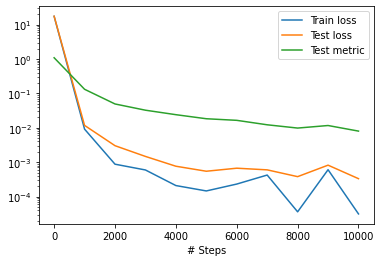

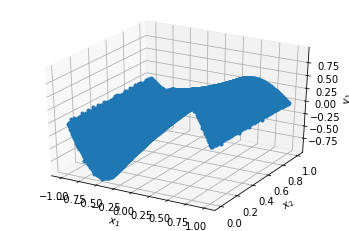

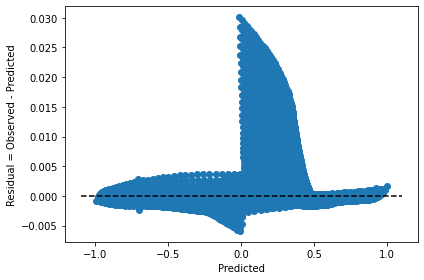

In [13]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)